# Dual Digital Pricing methods

The purpose of this notebook is to review dual digital pricing / sensitivities and to introduce realized correlation skew

## Contents
   - [Numerical Integration](#sec1)
       - [Present Value](#sec2)
       - [Partial Derivatives](#sec3)
   - [Montecarlo Simuation](#sec4)
       - [Results and Speed Comparaison](#sec5)
   - [Realized Skew](#sec6)
       - [Realized Volatility Skew](#sec7)
       - [Realized Correlation Skew](#sec8)

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import plotly.graph_objects as go
from module.pricing import DualDigital

# -----
# SET DISPLAY SETTINGS
# -----
pd.set_option('display.width', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<a id='sec1'></a>
## Numerical Integration

The following formula describes how the present value of the product is calculated: $ PV = Probability * CashFlow * Discount $

Where $Discount = e^{-rt} $ and the $Probability$ comes from the integration of the bivariate log-normal distribution (joint probability density function) defined as below

\begin{aligned}
& f_{X, Y}(x, y)=\frac{1}{2 \pi \sigma_1 \sigma_2 \sqrt{1-\rho^2} x y} \exp \left\{-\frac{1}{2\left(1-\rho^2\right)}\left[\left(\frac{\log x-\mu_1}{\sigma_1}\right)^2+\left(\frac{\log y-\mu_2}{\sigma_2}\right)^2 -2 \rho\left(\frac{\log x-\mu_1}{\sigma_1}\right)\left(\frac{\log y-\mu_2}{\sigma_2}\right)\right]\right\}
\end{aligned}

<br>

For example, for a up up dual digital we have 
$$Probability = \int_{K_{x}}^{+\infty}\int_{K_{y}}^{+\infty} f(x, y) dy dx $$


In [29]:
data = dict()
for st1 in tqdm(np.linspace(start=0.1, stop=2, num=20)):
    for st2 in np.linspace(start=0.1, stop=2, num=20):
        priceable = DualDigital(
            st1=st1, k1=1, iv1=0.2, q1=0, b1=0, direction1='down',
            st2=st2, k2=1, iv2=0.2, q2=0, b2=0, direction2='down',
            rho=0.8, r=0, t=1, unit=100, model='numerical_integration'
        )
        priceable.calculate_present_value()
        pv = priceable.get_present_value()
        data[(st1, st2)] = pv
data_df = pd.Series(data).unstack()

  0%|          | 0/20 [00:00<?, ?it/s]

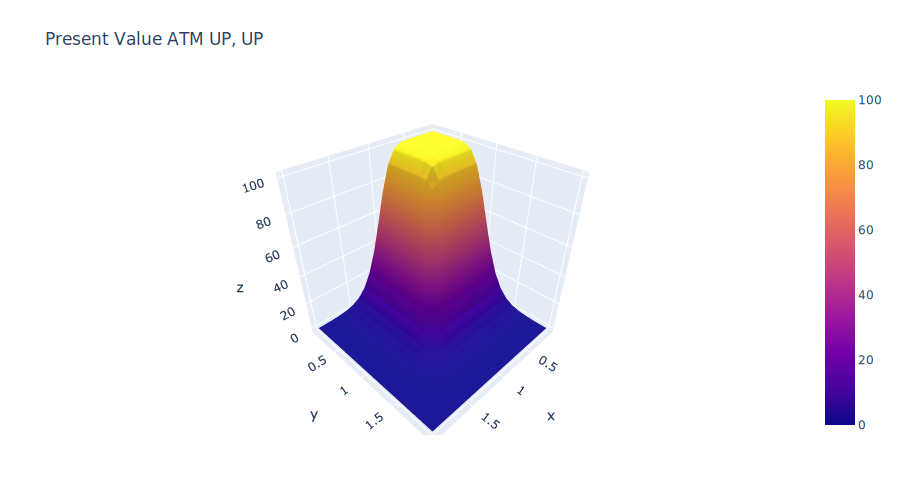

In [31]:
fig = go.Figure(data=[go.Surface(x=data_df.index, y=data_df.columns, z=data_df.values)])

fig.update_layout(title='Present Value ATM UP, UP', autosize=True,
                  width=900, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show('svg')

In [ ]:
# -------
# IMPORT DATA
# -------
df1 = pd.read_csv('data/SPY.csv', index_col=0, parse_dates=True).loc[:, ['Adj Close']]
df2 = pd.read_csv('data/IWM.csv', index_col=0, parse_dates=True).loc[:, ['Adj Close']]
df1.columns = ['st1']
df2.columns = ['st2']
df = pd.concat([df1, df2], axis=1).dropna()

In [ ]:
df_snap = df.iloc[-20:]
data = df_snap.to_dict(orient='index')

In [ ]:
df_snap.pct_change().std() * np.sqrt(252)

In [ ]:
df_snap.diff().corr()

In [ ]:
bt = Backtest(model='numerical_integration')

In [ ]:
results = bt.dual_digital(data=data, k1=1, k2=1, iv1=0.12, iv2=0.14, q1=0, q2=0, b1=0, b2=0, rho=0.8, r=0, unit=100)

In [ ]:
results.head()

In [ ]:
priceable1 = DualDigital(
    st1=100, k1=100, iv1=0.2, q1=0, b1=0, direction1='up',
    st2=100, k2=100, iv2=0.3, q2=0, b2=0, direction2='up',
    rho=0.8, r=0, t=1, unit=100, model='numerical_integration'
)
priceable1.calculate_present_value()
priceable1.calculate_greeks()
pv = priceable1.get_present_value()
greeks = priceable1.get_greeks()

In [ ]:
bump1 = 2
bump2 = 3
priceable1 = DualDigital(
    st1=100+bump1, k1=100, iv1=0.2, q1=0, b1=0, direction1='up',
    st2=100+bump2, k2=100, iv2=0.3, q2=0, b2=0, direction2='up',
    rho=0.8, r=0, t=251/252, unit=100, model='numerical_integration'
)
priceable1.calculate_present_value()
priceable1.calculate_greeks()
priceable1.get_present_value(), priceable1.get_greeks()

In [ ]:
delta1 = greeks.get('dst1') * bump1
delta2 = greeks.get('dst2') * bump2
delta = delta1 + delta2
gamma1 = greeks.get('dst1**2') * 0.5 * (bump1**2)
gamma2 = greeks.get('dst2**2') * 0.5 * (bump2**2)
gamma = gamma1 + gamma2
x_gamma = greeks.get('dst1*dst2') * (bump1*bump2)
theta = greeks.get('dt')
pnl = delta + gamma + x_gamma + theta
pv_new = pv + pnl
pv, pv_new